# MathFound - EXERCISE 3 - MLS FOR IMAGES, CURVES & PCA

### General Rules

**Plagiarism note.** Copying code (either from other students or from external sources) is strictly prohibited! We will be using automatic anti-plagiarism tools, and any violation of this rule will lead to expulsion from the class.

Late submissions up to 24h will be accepted with a penalty, except for extensions in case of serious illness or emergency. In that case please notify the assistant and provide a relevant medical certificate.

**Software.** All exercises of this course use Python.

**What to hand in.** Upload a .zip file of your solution in Moodle. The file must be called `MATHFOUND23-3-firstname-familyname.zip`. The `.zip` file MUST contain the following data inside:

* A jupyter notebook with the solution to the exercise and a description of what you implemented and comments/explanations on your results.

**OR** 

* The solution in `.py` format and a `readme.pdf` file containing a description of what you’ve implemented and instructions for running it, as well as explanations/comments on your results.

**Grading** This homework is 8.3% of your final grade. Your submission will be graded according to the quality of the images produced by your program, the conformance of your program to the expected behaviour of the assignment, and your understanding of the underlying techniques used in the assignment. The submitted code must produce exactly the same images included in your submission.

### Goal of this exercise

In this exercise you will apply what you learned about the Moving Least Squares (MLS) method to images and curves. You will read and implement parts of research papers that used MLS. In the second part you will apply PCA for data compression.

## Part 1 - Image deformation using MLS

The first task of this assignment is to write code which deforms images based on moving least squares as presented in the paper "Image Deformation using Moving Least Squares" by Schaefer et al. (provided with the exercise). In this paper, the authors propose a method to smoothly deform images using different kinds of transformations and allow the user to manipulate sets of points and segments to specify the deformations. For this exercise you will only focus on image deformations using sets of points.

Write a program which takes as input an image, some input and output control points and performs the deformation. The algorithm should follow the description from the paper. The three kinds of transformation, i.e. affine, similarity and rigid transformations should be supported by your program. Please note that we don't ask for an interactive application so that you don't need to worry about making the code fast (precomputation of some terms, approximation of the image by a grid), but you can do it if you wish.

Some pointers to help with your implementation:

* Read section 2 of the paper to understand the types of transformations you need to apply.
* Implement backwards warping to avoid artifacts (estimate transformation from the output points to the input points).
* You can use `scipy.ndimage.map_coordinates` to implement the warping process
* To optionally implement the image approximation by a grid for a significant speedup, you can use `numpy.meshgrid` and `scipy.interpolate.griddata`

Your result should resemble the following, where the green and red points are the input and output control points respectively.

![image.png](images/deformed_gingerbread.png)

### Required output

* **Code that deforms images according to user input using all three methods described above (affine, similarity and rigid).**
* **Representative image results of the gingerbread man (provided with the exercise) and at least one more image of your choice.**

### Selecting the control points interactively (optional)

If you want to create an interactive version of your image deformation code, you can look into using `ipywidgets` which allows you to set a callback function when the user clicks on the displayed image (with matplotlib). Any other solution is also fine (for example if you want to make a standalone `.py` for that part :).

#### Solution

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [3]:
def plot_deformed(ax, title: str, image: np.ndarray, p: np.ndarray, q: np.ndarray):
    ax.set_title(title)
    ax.imshow(image)    
    ax.scatter(p[:,0], p[:,1], edgecolors="lime", facecolors='none', marker="o")
    ax.scatter(q[:,0], q[:,1], color="red", marker="x")
    ax.axis("off")


In [4]:
image = plt.imread("data/ginger.png")

# control points
q = np.array([[160,50], [170, 160], [180, 270], [30, 160], [270, 155], [340, 160], [115, 370], [250, 370]])

# deformed positions
p = np.array([[160,50], [170, 160], [160, 280], [10, 250], [270, 110], [340, 70], [150, 370], [270, 360]])

In [9]:
# TODO: Implement image deformations

# Affine Transform

alpha = 1
image_affine = np.zeros(image.shape)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):

        v = np.array([j,i])
        abs_dist = np.linalg.norm(p - v, axis=1)

        #If v is a control point, then set new coords to deformation coordinate
        zero_index = np.where(abs_dist == 0)[0]

        if(np.size(zero_index)):
            i_new = p[zero_index, 1]
            j_new = p[zero_index, 0]
            image_affine[i, j] = image[i_new, j_new]
        else:
            w = 1 / np.power(abs_dist, 2*alpha)
            p_cent = np.dot(w, p) / np.sum(w)
            q_cent = np.dot(w, q) / np.sum(w)
            p_hat = p - p_cent
            q_hat = q - q_cent


            dif = (v-p_cent)
            M1 = np.linalg.inv(p_hat.T @ (w[:, np.newaxis] * p_hat))
            M2 = (p_hat.T @ (w[:, np.newaxis] * q_hat))
            f_a = dif @ M1 @ M2 + q_cent

            
            i_new = int(f_a[1])
            j_new = int(f_a[0])
            if(0 <= i_new and i_new < image.shape[0] and 0 <= j_new and j_new < image.shape[1]):
                image_affine[i, j] = image[i_new,j_new]

In [6]:
# Similarity Transform 

alpha = 1
image_similarity = np.zeros(image.shape)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):

        v = np.array([j,i])
        abs_dist = np.linalg.norm(p - v, axis=1)

        #If v is a control point, then set new coords to deformation coordinate
        zero_index = np.where(abs_dist == 0)[0]

        if(np.size(zero_index)):
            i_new = p[zero_index, 1]
            j_new = p[zero_index, 0]
            image_similarity[i, j] = image[i_new, j_new]
        else:
            w = 1 / np.power(abs_dist, 2*alpha)
            p_cent = np.dot(w, p) / np.sum(w)
            q_cent = np.dot(w, q) / np.sum(w)
            p_hat = p - p_cent
            q_hat = q - q_cent  

            mu = 0
            for k in range(p.shape[0]):
                mu += w[k] * (p_hat[k] @ p_hat[k].T)

            f_s = q_cent
            for k in range(p.shape[0]):
                # A_i computation can be taken out
                p_hat_swapped = np.column_stack((p_hat[k, 1], -p_hat[k, 0]))
                V1 = np.row_stack((p_hat[k,:], p_hat_swapped))
                cent_dist = v - p_cent
                cent_dist_swapped = np.column_stack((cent_dist[1], -cent_dist[0]))
                V2 = np.row_stack((cent_dist, cent_dist_swapped))
                A_i = w[k] * (V1 @ V2.T)
                f_s += (q_hat[k] @ ((1/mu) * A_i))

            
            i_new = int(f_s[1])
            j_new = int(f_s[0])
            #print("New:" + str(i_new) + " " + str(j_new))
            #print("i,j:" + str(i) + " " + str(j))
            if(0 <= i_new and i_new < image.shape[0] and 0 <= j_new and j_new < image.shape[1]):
                image_similarity[i, j] = image[i_new,j_new]

In [10]:
# Rigid Transform

alpha = 1
image_rigid = np.zeros(image.shape)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):

        v = np.array([j,i])
        abs_dist = np.linalg.norm(p - v, axis=1)

        #If v is a control point, then set new coords to deformation coordinate
        zero_index = np.where(abs_dist == 0)[0]

        if(np.size(zero_index)):
            i_new = p[zero_index, 1]
            j_new = p[zero_index, 0]
            image_rigid[i, j] = image[i_new, j_new]
        else:
            w = 1 / np.power(abs_dist, 2*alpha)
            p_cent = np.dot(w, p) / np.sum(w)
            q_cent = np.dot(w, q) / np.sum(w)
            p_hat = p - p_cent
            q_hat = q - q_cent  

            f_r_arr = 0
            for k in range(p.shape[0]):
                # A_i computation can be taken out
                p_hat_swapped = np.column_stack((p_hat[k, 1], -p_hat[k, 0]))
                V1 = np.row_stack((p_hat[k,:], p_hat_swapped))
                cent_dist = v - p_cent
                cent_dist_swapped = np.column_stack((cent_dist[1], -cent_dist[0]))
                V2 = np.row_stack((cent_dist, cent_dist_swapped))
                A_i = w[k] * (V1 @ V2.T)
                f_r_arr += q_hat[k] @ A_i

            f_r = np.linalg.norm(v - p_cent) * (f_r_arr / np.linalg.norm(f_r_arr)) + q_cent
            
            i_new = int(f_r[1])
            j_new = int(f_r[0])
            if(0 <= i_new and i_new < image.shape[0] and 0 <= j_new and j_new < image.shape[1]):
                image_rigid[i, j] = image[i_new,j_new]

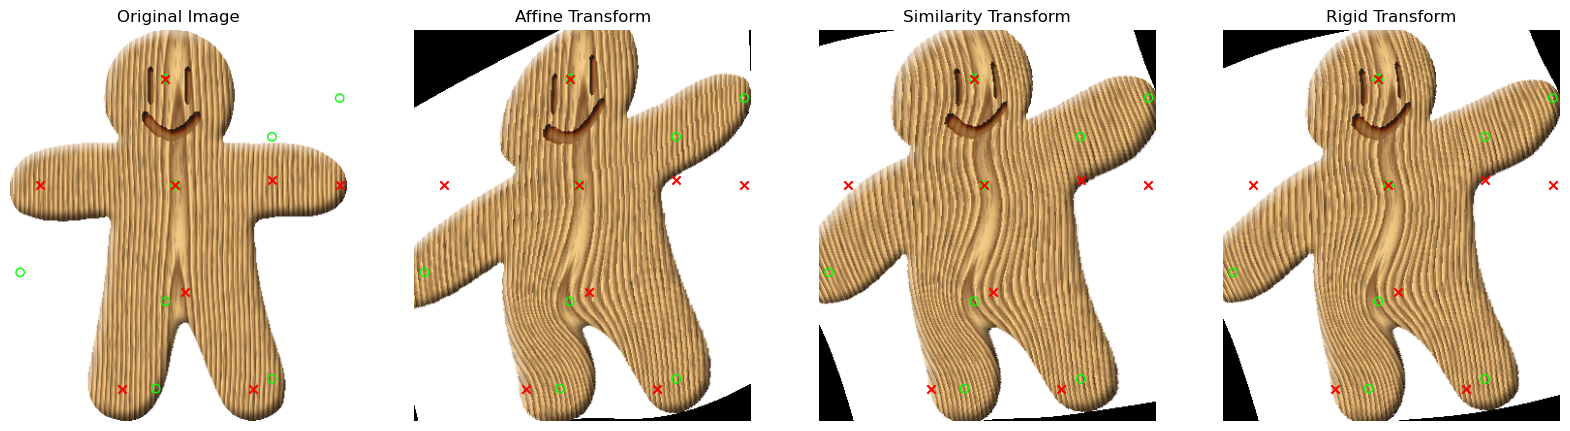

In [11]:
# Plot figures
fig, axes = plt.subplots(1, 4, figsize=(20,18))

plot_deformed(axes[0], "Original Image", image, p, q)
plot_deformed(axes[1], "Affine Transform", image_affine, p, q)
plot_deformed(axes[2], "Similarity Transform", image_similarity, p, q)
plot_deformed(axes[3], "Rigid Transform", image_rigid, p, q)

#for i, title in enumerate(["Original Image", "Affine Transform", "Similarity Transform", "Rigid Transform"]):
#    plot_deformed(axes[i], title, image_affine, p, q)

plt.show()
plt.close(fig)

## Part 2 - Curve and Surface Reconstruction Using MLS

As described in the lectures, moving least squares (MLS) can be used to approximate a function given samples from that function at sample points. In this exercise, we will utilize this method to reconstruct curves. We provide a few example datasets.

### Implicit MLS Surfaces

Given some samples points and attributes (i.e. normals, colors), we seek to find a function $f(\mathbf{x}) : \mathbb{R}^2 \rightarrow \mathbb{R}$ such that the curve is given by $\mathcal{S} = \{ \mathbf{x} \vert f(\mathbf{x}) = 0, \nabla f(\mathbf{x}) \neq \mathbf{0} \}$

### Curves derivation

MLS based surfaces can be computed by considering different degrees for the local approximations and constraints, as described in the lectures. The first part of the exercise is to derive on paper one of the simplest definitions for MLS based surfaces. For this task, we assume that the locally fit polynomial consists of a single constant term, $f(\mathbf{x}) = c_0$,

$$
\underset{c_0}{\operatorname{argmin}}\sum_i \phi(||\mathbf{x} - \mathbf{x}_i||)(c_0 - f_i(\mathbf{x}))^2
$$

Using the following local functional approximation

$$
f_i(\mathbf{x}) = \mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})
$$

**derive the closed-form expression for the resulting implicit function** $f(\mathbf{x})$.

Hint: it is a weighted least squares problem for the scalar $c_0$, and hence reduces to a simple normalized average.

#### Solution

_write your answer here_

### Curves plotting

Evaluate the derived $f(\mathbf{x})$ for the given example point sets with 2D points and normals, on a regular grid. For the definition of $\phi$, use a Gaussian of a chosen $\sigma$ such that $\phi(r) = e^{-r^2/\sigma^2}$. Initialize a matrix representing the grid. Then, for each grid center, evaluate the function $f$ and store the value at the entry of the matrix corresponding to that grid. Finally, plot this matrix as a heatmap or similar, overlaid with the sample points in the same image (as shown below). Optionally visualize the zero level set of the matrix (in orange).

![image.png](images/curves.png)

Generate **a few images with different $\sigma$ values to illustrate how it affects the approximation and discuss your results**. You can see the reconstructed curve by observing the values of $f$ close to zero. How is the value of $\sigma$ influencing the results ?

#### Implementation hints

* You can use `imshow` from `matplotlib` to visualize the matrix
* If the plotted $f(\mathbf{x})$ looks too smooth, try decreasing $\sigma$. Similarly, if you get discountinuous $f(\mathbf{x})$, try increasing $\sigma$.
* You can use numpy to load the data:


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

curve_data = np.load('data/curve_data1.npz')
points = curve_data['points']
normals = curve_data['normals']

plt.plot(points[:,0], points[:,1])

plt.show()
plt.close()

### Solution

In [ ]:
# Curve plotting functions to help you get started, feel free to modify
import matplotlib.colors

def plot_curve(fig, ax, points, x, y, grid):
    extent = (np.min(x), np.max(x), np.min(y), np.max(y))
    norm = matplotlib.colors.TwoSlopeNorm(vcenter=0.0)
    
    mappable = ax.imshow(grid, origin="lower", extent=extent, cmap="RdBu", norm=norm)
    ax.plot(points[:,0], points[:,1], color="blue")
    ax.contour(x, y, grid, levels=[0], colors="orange")
    
    fig.colorbar(mappable, ax=ax)

In [ ]:
NX, NY = 300, 200  # grid resolution
x_axis = np.linspace(-2.2, 2.2, NX)
y_axis = np.linspace(-1.5, 2.5, NY)

fig, axis = plt.subplots(1, 3, figsize=(16, 3.5))

for curve_i, ax in enumerate(axis):
    curve_data = np.load(f'data/curve_data{curve_i + 1}.npz')
    points = curve_data['points']
    normals = curve_data['normals']  # not normalized!

    grid = np.ascontiguousarray([x_axis] * NY)

    # TODO - fill the `grid` with f(x) values

    plot_curve(fig, ax, points, x_axis, y_axis, grid)


#### Bonus exercise - numerically stable implementation

_Added to Exercise 3, maximum points cannot exceed 100%_

You will observe that with small $\sigma$, the function $f$ becomes numerically unstable at some regions of the grid. Dervive and implement numerically stable verison of $f(\mathbf{x})$ with the given $\phi(r)$

## Part 3 - Image Compression using PCA

As described in the lecture, PCA is a powerful technique commonly used in machine learning and image processing to reduce the dimensions of data while preserving its important features. This is particularly useful when working with large datasets, as it can help reduce the computational complexity of your algorithms while maintaining the quality of the data.

In this small exercise, you will use PCA to compress a **single** image by reducing the number of dimensions along its rows. This will help you gain a better understanding of how PCA works and how it can be used in real-world applications. You will be given a sample image, and your task will be to apply PCA to it to reduce its dimensions while minimizing the loss of information.

You will be given two programming tasks to complete:

### Plotting Reduced Images: 
Write a Python function `pca_on_cols(image, n_comps)` that takes an image and an integers n_comps as input and plots the compressed/reconstructed image obtained by projecting the image rows onto n_comps principal components. 
To test the function and compare different results depending on the number of used principal components, run the function `plot_reduced_images(image, n_comps)` that takes the test image and a list of integers n_comps as input and plots the compressed/reconstructed images obtained by calling your `pca_on_cols` function.

### Plotting Variance vs. Components: 
Write a Python function `plot_variance_vs_components(image)` that takes an image as input and plots the variance maintained as a function of the number of principal components kept. This will help you to determine how many principal components to keep in order to achieve a desired level of compression.

*Hint:* You are allowed to use [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to solve the tasks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Tuple, List
from sklearn.decomposition import PCA

In [ ]:
def pca_on_cols(image: np.ndarray, n_comps: int) -> Tuple[np.ndarray, np.ndarray]:
    """Applies PCA on the rows of the image, separately on the three color channels and reconstructs
    the image using the reduced representations of each color channel. 
    
    Args:
            image (ndarray) - Input image of shape (height, width, 3) where 3 represents the three color 
                                channels (blue, green, red).
            n_comps (int)   - Number of principal components to keep for each color channel
    
    Returns:
            A tuple containing the reconstructed image of the same shape as the input image, and 
            the cumulative explained variance ratio averaged over the PCA for each color channel.
    """
    
    img_reduced = image
    explained_variance = 0
    
    #TODO START
    
    
    #TODO END
    return img_reduced, explained_variance

In [ ]:
def plot_variance_vs_components(image):
    """Computes the cumulative explained variance of principal component analysis (PCA) on each color 
    channel of an input image and plots it against the number of principal components. 
    
    Args:
        image (np.ndarray) - Input image of shape (height, width, 3) where 3 represents the three color 
                             channels (blue, green, red).
    
    Plots:
        A line plot of the cumulative explained variance vs. the number of principal components.
    """
    cumulative_variance = 0
    #TODO START
    
    #TODO END
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs. Number of Principal Components')
    plt.show()

In [ ]:
def plot_reduced_images(image: np.ndarray, n_comps: List[int]):
    """Reduces an input image using principal component analysis (PCA) with different numbers of 
    components and plots the reduced images side by side.
    
    Args:
        image (np.ndarray) - Input image of shape (height, width, 3) where 3 represents the three color 
                             channels (blue, green, red).
        n_comps (int or List[int]) - Number(s) of principal components to use for reducing the image. 
        
    Plots:
        A grid of reduced images, one for each number of principal components specified in n_comps.
    """
    _, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,24))
    i = 0
    
    for n in n_comps:
        ax = axes.flat[i]
        image_reduced, _ = pca_on_cols(image, n_comps = n)
        ax.imshow(image_reduced)
        ax.set_axis_off()
        ax.set_title(f"Reduced image on {n} components")
        i += 1
    
    plt.tight_layout()
    plt.show()

In [ ]:
image = plt.imread('data/ethz.png')

plot_variance_vs_components(image)
plot_reduced_images(image, n_comps = [1, 2, 3, 5, 10, 20, 50, 100, 250, image.shape[0]])

### Theoretical question
Imagine now you are given $N$ RGB face images $\{\mathbf{x}_i\}_{i=1}^N$ of size $3\times H\times W$ and you want to compress them along the rows as you have done for a single image in the programming part (i.e. perform PCA along the rows for each color channel separately). As you already know, this can be done by computing the eigenfaces $\mathbf{u}_k$ of these images and representing the images as a linear combination of eigenfaces:
$$\mathbf{\hat{x}}_i = \sum_{k=1}^K [z_{i,k} \mathbf{u}_k] + \mathbf{\bar{x}}$$
You have already implemented your pipeline. To obtain the eigenfaces, you have been following the generic procedure

* Split image into three parts for each channel and make each part 1D
* Calculate the per-pixel mean image for each color channel
* Normalize the images (subtract mean from all images)
* Generate the covariance matrices for each part
* Get Eigenvectors of the covariance matrix for each part
* Keep the Eigenvectors with the $K$ largest Eigenvalues for each part

In this procedure you need to specify the number of eigenfaces $K$ manually. The more eigenfaces you use the better the compression but the more storage space is needed. **What is the maximal value for $K$ with which you can still reduce storage space by compression?** 

Please consider all information required to decompress an image or compress a new one. Note that you are storing images as arrays (e.g. the original images are stored as arrays of size $3\times H\times W$ each) and are not using any other compression like JPEG etc.. We assume that all numbers and array entries take the same amount of storage space.

#### Answer

Your answer here (Type *Markdown* and LaTeX: $\alpha^2$)